## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
!ls images

download_ex.png      key_pts_example.png     moustache.png   the_beatles.jpg
face_filter_ex.png   landmarks_numbered.jpg  obamas.jpg
feature_map_ex.png   michelle_detected.png   straw_hat.png
haar_cascade_ex.png  mona_lisa.jpg	     sunglasses.png


#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

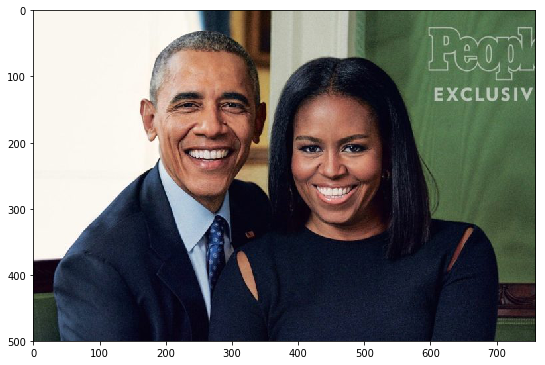

In [3]:
import cv2
# from torchvision import transforms
# from data_load import Rescale, RandomCrop, Normalize, ToTensor

# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = rescale_image(image, output_size=224)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


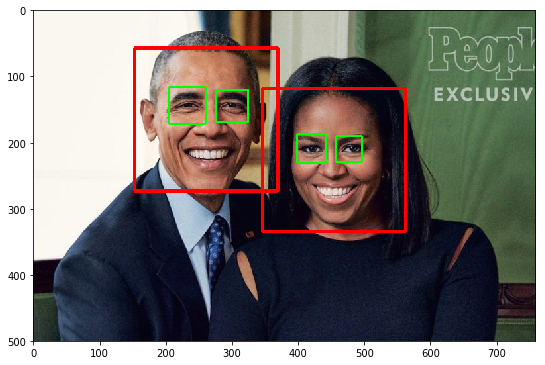

In [4]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_eye.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 3, 2) # tested and also see it from link above

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found add code for eye_cascade from link
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3)
    # draw a rectangle around each detected eyes
    eyes = eye_cascade.detectMultiScale(gray)    
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(image_with_detections,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)


## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [5]:
import torch
from models import Net

net = Net()
net.cuda()

# Load the best saved model parameters (by your path name)
# smoothl1loss_adam_16_5conv_batch_facial_68keypoints_10epochs_1.pt
net.load_state_dict(torch.load('saved_models/smoothl1loss_adam_16_5conv_batch_facial_68keypoints_10epochs_1.pt'))

# Print out your net and prepare it for testing 
net.eval()



Net(
  (findFeatures): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2,

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

**Hint**: The sizes of faces detected by a Haar detector and the faces your network has been trained on are of different sizes. If you find that your model is generating keypoints that are too small for a given face, try adding some padding to the detected `roi` before giving it as input to your model.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




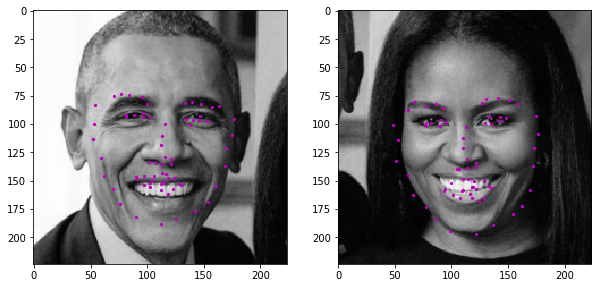

In [16]:
from torch.autograd import Variable

image_copy = np.copy(image)

fig = plt.figure(figsize=(10,5))
for i, (x,y,w,h) in enumerate(faces):
 
    padding = 20
    # Crop the region of intrest
    roi = image_copy[y - padding: y + h + padding, x - padding: x + w + padding]
    
    # Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    
    # Normalize the grayscale image [0,255]-->[0,1]
    roi = roi / 255.0
    # Rescale the detected face for CNN --> (224, 224)
    face = cv2.resize(roi, (224,224)) 
    face_image = face.reshape(1, face.shape[0], face.shape[1], 1).transpose((0, 3, 1, 2))
    
    #Make facial keypoints using my CNN
    face_image = Variable(torch.from_numpy(face_image).type(torch.FloatTensor).cuda())
    
    
    # forward pass to get net output
    output_pts = net(face_image)
    output_pts = output_pts.cpu()
    
    # un-trasform the predicted key_pts data
    predicted_key_pts = output_pts.data
    predicted_key_pts = predicted_key_pts.numpy()
    
    #reshape to batchsize x 68 x 2 pts
    predicted_key_pts = predicted_key_pts[0].reshape((68, 2))
    
    # usdo normalization keypoints
    output_pts = predicted_key_pts*66.0+100.0

    # Show faces with keypoints    
    fig.add_subplot(1, 2, i+1)
    plt.imshow(face, cmap='gray')
    plt.scatter(output_pts[:, 0], output_pts[:, 1], s=20, marker='.', c='m')